In [221]:
import numpy as np
import matplotlib.pyplot as plt

# Generate Some Categorical Data

In [222]:
samples = 100
X1 = np.concatenate((np.random.normal(0, 1, samples), np.random.normal(5, 1, samples)))
X2 = np.concatenate((np.random.normal(0, 1, samples), np.random.normal(5, 1, samples)))
X = np.vstack((X1, X2))
S = np.concatenate((np.zeros(samples), np.ones(samples)))

In [223]:
marks = S.tolist()

In [224]:
marks[marks == 0] = 'x'
marks[marks == 1] = '.'

Text(0, 0.5, 'X2')

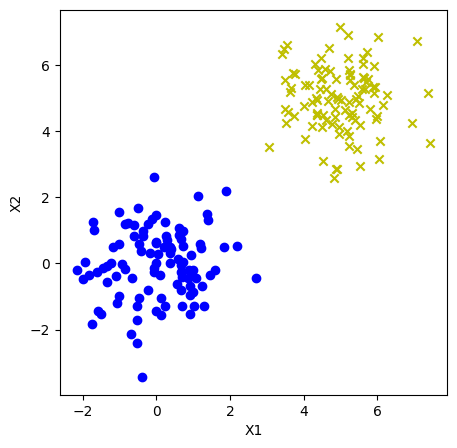

In [225]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X1[S==0], X2[S==0], c='b', marker='o')
plt.scatter(X1[S==1], X2[S==1], c='y', marker='x')
plt.xlabel('X1')
plt.ylabel('X2')

# Naive Bayes

The Naive Bayes model is based on the Bayes theorem 
$$P(B|A) = \frac{P(A|B)P(B)}{P(A)}$$

Let $B_1$ and $B_2$ be two classes, and $X_1 \text{ and } X_2$ be two features based on which new entries are to be classified. Then, the Naive Bayes algorithm calculates the following two probabilities:

$$P_1 = P(B_1) P(X_1 | B_1) P(X_2 | B_1)$$
and
$$P_2 = P(B_2) P(X_1 | B_2) P(X_2 | B_2)$$

If $P_1 > P_2$, the new entry gets classified as $B_1$, and vice versa. 

The prior probabilities $P(B_1)$ and $P(B_2)$ can be calculated by taking proportions of $B_1$ and $B_2$ examples in the training dataset, while the conditional probabilities are calculated by finding proportions of seeing the features $X_1$ and $X_2$ in each class.

In the case of continuous data, these probabilities are replaced by likelihood values from gaussian (or any other distribution) fitted to each feature in case of each class. 

### Problem(s)

- In case of missing features in training data for some class, the conditional probability becomes 0. This leads to a 0 value of $P_c$ even if otherwise it would be high. This is solved by adding a pseudocount to the instances of each feature in each class. 
- Multiplying very small probabilities can lead to underflow issues. This is solved by taking sum of log-likelihoods instead of product of likelihoods. 

# Find Prior and Fit Gaussian Curve to Each Feature for Each Class

In [226]:
min_x = np.inf
max_x = -np.inf
for i in range(X.shape[0]):
    if min(X[i, :]) < min_x:
        min_x = min(X[i, :])
    if max(X[i, :]) > max_x:
        max_x = max(X[i, :])

pdf_x_axes = np.linspace(min_x, max_x, 1000, endpoint=True)

In [230]:
import seaborn as sns

classes = [0, 1]

pdfs_dict = {}

for i in classes:

    pdfs = {}

    for j in range(X.shape[0]):

        if j == 0:
            pdfs['Prior'] = (len(S[S==i]) + 1) / (len(S) + len(classes))

        fig, ax = plt.subplots()
        sns.kdeplot(X[j, :][S == i], ax=ax, bw_adjust=1)
        plt.close()
        line = ax.get_lines()[0]
        x_vals = line.get_xdata()
        y_vals = line.get_ydata()

        pdfs[f'Feature_{j+1}'] = np.interp(pdf_x_axes, x_vals, y_vals)

    pdfs_dict[f'Class_{i}'] = pdfs

# Function for Calculating $P_c$

In [231]:
def P_c(data, class_dict, pdf_x):

    prob = class_dict['Prior']
    for i in range(data.shape[0]):
        prob = prob * class_dict[f'Feature_{i+1}'][np.argmin(np.abs(pdf_x - data[i]))]

    return prob

# Testing on Train Data

In [232]:
probability_matrix = np.zeros((X.shape[1], len(classes)))

In [233]:
predict_S = np.zeros_like(S)

In [234]:
for i in range(X.shape[1]):
    for j in classes:
        probability_matrix[i, j] = P_c(X[:, i], pdfs_dict[f'Class_{j}'], pdf_x_axes)

for i in range(X.shape[1]):
    predict_S[i] = np.argmax(probability_matrix[i, :])

Text(0, 0.5, 'X2')

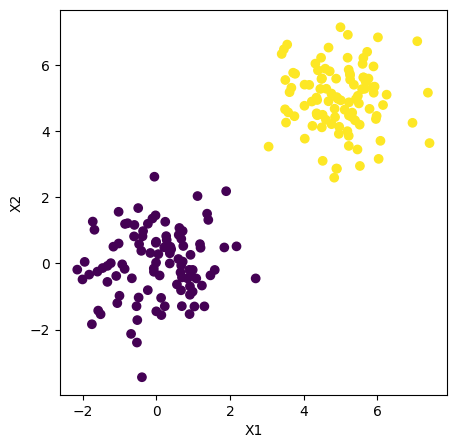

In [235]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X1, X2, c=predict_S)
plt.xlabel('X1')
plt.ylabel('X2')

# A Neater Approach With OOP

In [276]:
import seaborn as sns

class NaiveBayesClassifier():
    def __init__(self):
        self.pdfs_dict = None
        self.pdf_x_axes = None
        self.classes = None
    
    def get_pdf_x(self, X):
        min_x = np.inf
        max_x = -np.inf

        for i in range(X.shape[0]):
            if min(X[i, :]) < min_x:
                min_x = min(X[i, :])
            if max(X[i, :]) > max_x:
                max_x = max(X[i, :])
        self.pdf_x_axes = np.linspace(min_x, max_x, 1000, endpoint=True)


    def P_c(self, data, class_dict):

        prob = class_dict['Prior']
        for i in range(data.shape[0]):
            prob = prob * class_dict[f'Feature_{i+1}'][np.argmin(np.abs(self.pdf_x_axes - data[i]))]

        return prob

    def fit(self, X, y):

        self.classes = np.unique(y).astype('int')

        self.pdfs_dict = {}

        self.get_pdf_x(X)

        for i in classes:

            pdfs = {}

            for j in range(X.shape[0]):

                if j == 0:
                    pdfs['Prior'] = (len(y[y==i]) + 1) / (len(y) + len(classes))

                fig, ax = plt.subplots()
                sns.kdeplot(X[j, :][y == i], ax=ax, bw_adjust=1)
                plt.close()
                line = ax.get_lines()[0]
                x_vals = line.get_xdata()
                y_vals = line.get_ydata()

                pdfs[f'Feature_{j+1}'] = np.interp(self.pdf_x_axes, x_vals, y_vals)

            self.pdfs_dict[f'Class_{i}'] = pdfs

    def predict(self, X):

        probability_matrix = np.zeros((X.shape[1], len(self.classes)))
        predict_y = np.zeros(X.shape[1])
        for i in range(X.shape[1]):
            for j in self.classes:
                probability_matrix[i, j] = self.P_c(X[:, i], self.pdfs_dict[f'Class_{j}'])

        for i in range(X.shape[1]):
            predict_y[i] = np.argmax(probability_matrix[i, :])

        return predict_y

In [278]:
naiveb = NaiveBayesClassifier()
naiveb.fit(X, S)

Text(0, 0.5, 'X2')

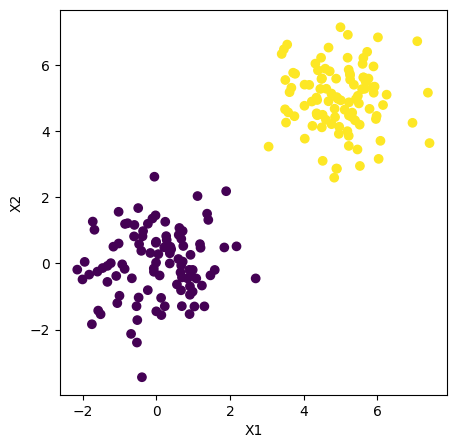

In [279]:
pred = naiveb.predict(X)

fig = plt.figure(figsize=(5, 5))
plt.scatter(X[0, :], X[1, :], c=pred)
plt.xlabel('X1')
plt.ylabel('X2')

# Make Some New X, S for Prediction Using Similar Scheme As Train Data

(Could have split data into test and train instead of doing this)

In [280]:
samples = 10
X1_test = np.concatenate((np.random.normal(0, 1, samples), np.random.normal(5, 1, samples)))
X2_test = np.concatenate((np.random.normal(0, 1, samples), np.random.normal(5, 1, samples)))
X_test = np.vstack((X1_test, X2_test))
S_test = np.concatenate((np.zeros(samples), np.ones(samples)))

In [281]:
predictions = naiveb.predict(X_test)

Text(0, 0.5, 'X2')

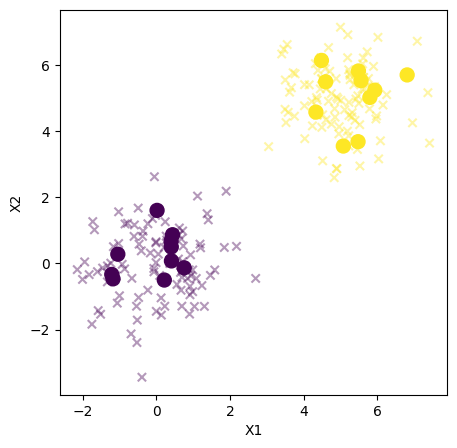

In [292]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X_test[0, :], X_test[1, :], c=predictions, marker='o', s=100)
plt.scatter(X[0, :], X[1, :], c=S, marker='x', alpha=0.4)
plt.xlabel('X1')
plt.ylabel('X2')